# Estimations des paramètres libres 

## Tâche expérimentale et modèle
La tache que nous utilison pour illuster l'estimation des parametres libres est celle des slot-machines. Nous alons utiliser le modèle Q learning vu dans les cours sur les simulations.




## Estimation des paramètres

L'idée de l'estimation des parametres libres c'est de reussir à identifier la valuer des parametres du modèle (le taux d'apprentissage et la temperature) qui engendre des choix qui ressemblement le plus possibles à celles du participant.



## Méthode 1: Grid Search

La première méthode que nous allons utiliser est celle du Grid search, qui consiste à simuler la probabilité de choisir du modèle et voir à quel point elle décrit bien le comportement du participant.

Pratiquement la méthode du grid search consiste à engendré les probabilité de choix du modèle avec toutes les combinaisons de parametres ( $ \alpha $ $ \beta $) possibles voir à quel point cela décrit bien le comportement du participant (en calculant la vraisemblances des données) et de selectionner le pair qui engendre les prédictions du modèle qui correspond le mieux ("fit") au comportement observé.

Théoriquement, le but de la méthode "Grid Search" est celle de trouver les valuers des parametres libres ($ \alpha $ et $ \beta $) qui maximise la probabilité des données observées (les choix du participant), étant donnée le modèle que nous avons (Qmodel). 

$$
p(data | model)
$$

Cette quantité est aussi connue comme la vraisemblance (*likelihood*) des données.




### Code du "Grid Search" pour le Qmodel avec plusieurs bloques d'apprentissage

Dans cette partie du code nous allons faire appel à des fonctions. Dans cette partie, il nous suffit de savoir que nous avons deux dossiers qui contiennent deux fonctions différentes auxquelles nous allons faire appel plus tard:

- **dans le dossier "my_models" :** il y a une fonction qui s'appelle Qmodel, qui produit des choix simulés du modèle avec certains paramètres libres (alpha et inv_temp) et certaines caractéristiques de la tâche expérimentale comme le nombre d'essais (ntrials) et le nombre de blocs d'apprentissage (nruns)..

- **dans le dossier "my_functions" :** il y a une fonction qui s'appelle estimateQ_gridsearch qui exécute le grid search pour trouver les meilleures valeurs des paramètres libres du Qmodel, étant donné les choix (ch) et l'historique des récompenses obtenues (r) ainsi que les caractéristiques de la tâche (nruns) d'un certain participant.



### Code étape 1 : définir ou trouver les fonctions 

attention pour que cela marche, il faux executer le script à partir du dossier "3-estimer_parametres"

In [25]:
here = pwd;

home = fullfile(here,'3-estimer_parametres')

addpath(genpath(fullfile(home,'my_models')));
addpath(genpath(fullfile(home,'my_functions')));


home = '/Users/pool/Documents/Teaching/PA/AdvanceSignal/code/3-estimer_parametres'

S'il vous plait, vérifiez bien la variable *"here"* correspond au chemin où le dossier "3-estimer_parametres" se trouve sur notre ordinateur.

### Code étape 2 : définir les caractéristiques de la tâche

Nombre d'essais et nombre de bloques d'apprentissage

In [12]:
ntrials =  24;
nruns   =  50;

### Code étape 3: créer un participant sythetique

Nous n'avons pas de vraies données, nous allons simuler des choix d'un participant synthétique (sim_ch) avec deux valeurs de paramètres libres que nous allons fixer au préalable. Dans un cas normal, nous ne connaissons pas ces paramètres et nous mesurons simplement les choix des participants.

La function Qmodel a comme variables input:
- la valuer de $\alpha$ : sim_alpha
- la valuer de $\beta$ : sim_inv_temp
- le nombre d'essais : ntrial
- le nombre de bloques d'apprentissate : nruns

et comme variables output elle va renvoyer:
- les choix du participant simulé : sim_ch
- l'historique des récompenses délivrées à ce participant pendant la tâche : sim_r


In [42]:
sim_alpha    = 0.3;
sim_inv_temp = 1.5;


[sim_ch, sim_r] = Qmodel (sim_alpha, sim_inv_temp, ntrials, nruns);


Attention, la fonction est stochastique et génère des séries temporelles similaires mais différentes à chaque fois.

### Code étape 4: faire un grid search pour trouver les valeurs des paramètres libres qui mieux décrit les choix du participant (sythetique).

Le résultat du Grid search est une carte de la somme négative de la vraisemblance transformée en log (negative log likelihood, nLL) pour toutes les combinaisons des valeurs du taux d'apprentissage et de la température inverse. Le point rouge indique la combinaison de paramètres qui minimise la vraisemblance négative.


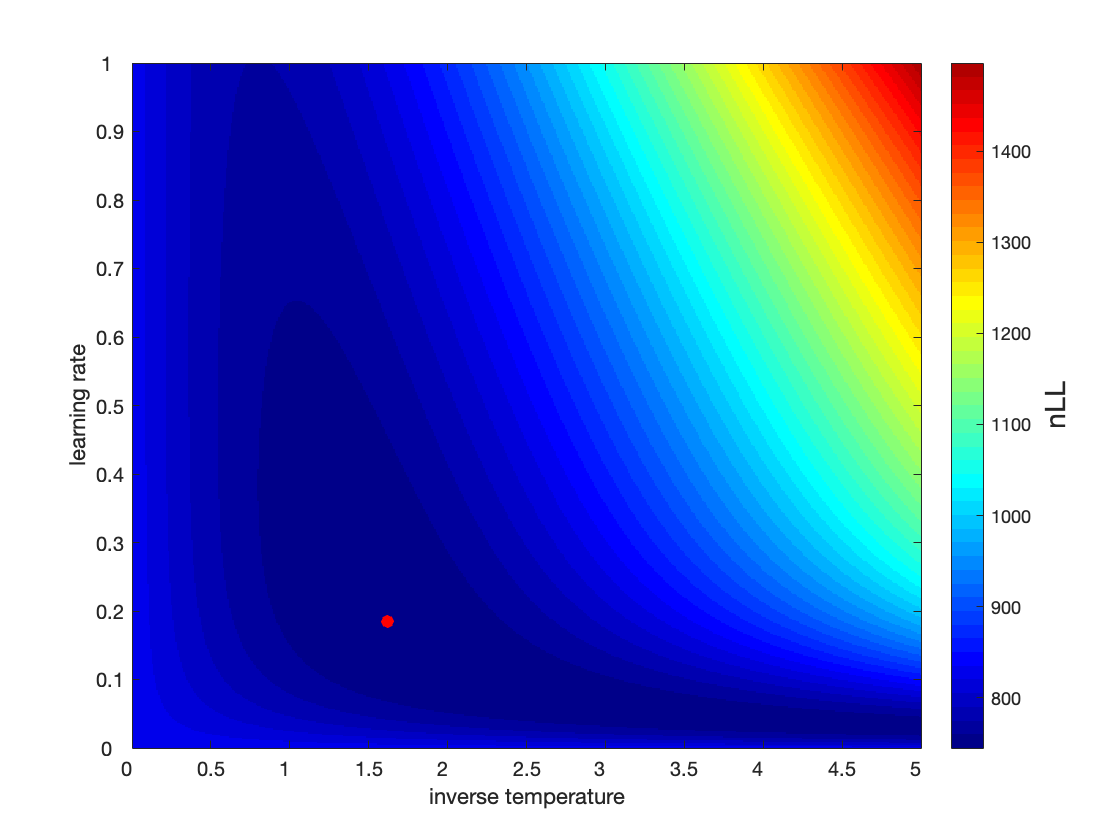

alpha =0.182
inv. temp =1.62


In [18]:

[est_alpha, est_temp] = estimateQ_gridsearch(sim_ch, sim_r, nruns);

 ### Limites et Avantages du "Grid Search"
 
 Cette approche d'estimations à des avantages mais aussi des limites importantes.
 
 Entre les avantages:
 
 - conceptuellement simple
 - facile à mettre en œuvre 
 - résultats sont faciles à visualiser
 
 Entre les désavantages:
 
 - n'est pas implemetables avec des modèles ayant plusieurs paramètres libres
 - lourd en temps de calcul et mémoire, même pour des intervalles relativement grossiers
 - pas possible de contraindre vos paramètres en utilisant des priors informatifs
 - pas possible de utiliser des prior "empiriques" (le cadre d'une approche de modèle mixte hiérarchique)
 


 

### Approfondissement du code de la fonction estimateQ_gridsearch

Dans cet approfondissement, nous allons voir en détail le code de la fonction qui exécute le grid search pour le Qmodel. Comme dans MATLAB nous ne pouvons pas définir les fonctions dans le script principal, nous allons légèrement la modifier pour pouvoir exécuter le code.

Premièrement, nous allons mettre la déclaration de la fonction en commentaire

In [21]:
% function [est_alpha, est_temp] = estimateQ_gridsearch(ch, r, nruns)

Ensuite, nous allons définire les variables qui sont normalement entrées comme input de la fonction:

In [44]:
ch    = sim_ch;
r     = sim_r;
nruns = nruns; % cela est pas nécessaires

Maitenant, nous pouvons executer le code de la fonction ligne par ligne. Nous commencant avec les caractéristiques de la tâche.

In [45]:
% définir la valeur initiale
Q0  = [0 0]; 

% nombre d'essais
ntrials = size(ch,1); % on détermine le nombre d'essais à partir du nombre de choix du paritcipant


Après, on détermine le possibles valeurs des paramètres libres que nous voulons explorer.

In [29]:
% taux d'apprentissage alpha varies entre 0 to 1 avec 201 étapes
alpha_mat = linspace(0,1, 201);

% temperature inverse varies entre 0 to 1 avec 201 étapes
temp_mat  = linspace(0, 5, 201);

Selon l'espace que nous avons défini ci-dessus, nous initialisons une matrice vide dans laquelle nous allons sauvegarder la vraisemblance (negative log-likelihood, nLL) de chaque combinaison de paramètres.

In [46]:
% initialiser la matrice de vraisemblance pour chaque combinaison de paramètres
nLL = NaN(numel(alpha_mat),numel(temp_mat));

Tout est prêt pour commencer à explorer l'espace des paramètres que nous avons défini. Nous allons procéder avec deux boucles for imbriquées l'une dans l'autre. La première lit de manière séquentielle les valeurs d'alpha et la deuxième les valeurs de la température inverse. Donc, pour une valeur d'alpha, nous allons examiner toutes les valeurs possibles de beta, puis passer à la prochaine valeur de alpha et ainsi de suite.

Ce qui est important dans cette partie, c'est de comprendre où les simulations du modèle et les données du participant sont comparées : nous utilisons le modèle pour calculer la probabilité de choisir (PA), ensuite nous utilisons cette probabilité pour voir si elle prédit bien le choix du participant (ch). C'est ainsi que nous calculons la vraisemblance (lik) à chaque essai.

À la fin des essais, nous calculons la somme négative de la transformation en log de la vraisemblance à chaque essai.

Attention, quand vous exécutez cette partie du code, cela va prendre longtemps (comme discuté dans les limites de cette approche ci-dessous).

In [ ]:
%% explorer

% commençons par explorer la vraisemblance des choix avec toutes les
% combinaisons possibles

for a = 1:size(alpha_mat,2)

    alpha = alpha_mat(a); % sélectionner une valeur possible du taux d'apprentissage


    for b = 1:size(temp_mat,2)

        inv_temp = temp_mat(b); % sélectionner une valeur possible de température


        % initialiser les variables du modèle
        PA = NaN(ntrials,1);
        lik = NaN(ntrials,1);
        Qt = NaN(ntrials,2);
        PE = NaN(ntrials,1);

        % valeur avant le début de l'apprentissage
        Qt(1,:)  = Q0;

        for t = 1:ntrials

            if  mod(t,(ntrials/nruns)) == 0
                % initialiser la valeur pour chaque série
                Qt(t,:)  = Q0;
            end

            % calculer la probabilité de choisir A du modèle
            PA(t)   = 1./(1+exp(-inv_temp.*(Qt(t,2)-Qt(t,1))));

            % voir à quel point le choix du modèle correspond au choix du
            % participant
            if ch(t) == 1 % si le participants a choisit B
                lik(t) = 1 - PA(t);
            elseif ch(t) == 2 % si le particiapnts a choisit A
                lik(t) = PA(t);
            end

            % calculer l'erreur de prédiction sur la base de la récompense
            % délivré au participant (r)
            PE(t) = r(t) - Qt(t,ch(t));

            %mis à jours de la valeur
            Qt(t+1,ch(t)) = Qt(t,ch(t)) + alpha.*PE(t);    % colonne ch(t) = choisie (1 ou 2)
            Qt(t+1,3-ch(t)) = Qt(t,3-ch(t));               % colonne 3-ch(t) = non choisie (2 ou 1)

        end

        % calculer à quel point les choix du participants étaient probables
        % avec ces parametres du modèle
        nLL(a,b) = -sum(log(lik(:)));


    end % fin température

end % fin taux d'apprentissage



Maintenant que nous avons les valeurs de la vraisemblance négative pour chaque combinaison, il faut juste trouver la combinaison de paramètres qui a engendré la plus petite valeur.

In [32]:
% obtenire les valeur de alpha et de la température estimées

[I,J] = find(nLL == min(min(nLL)));

est_alpha = alpha_mat(I);
est_temp = temp_mat(J);


Et finalement, nous pouvons visualiser le résultat de l'estimation à travers un graphique.

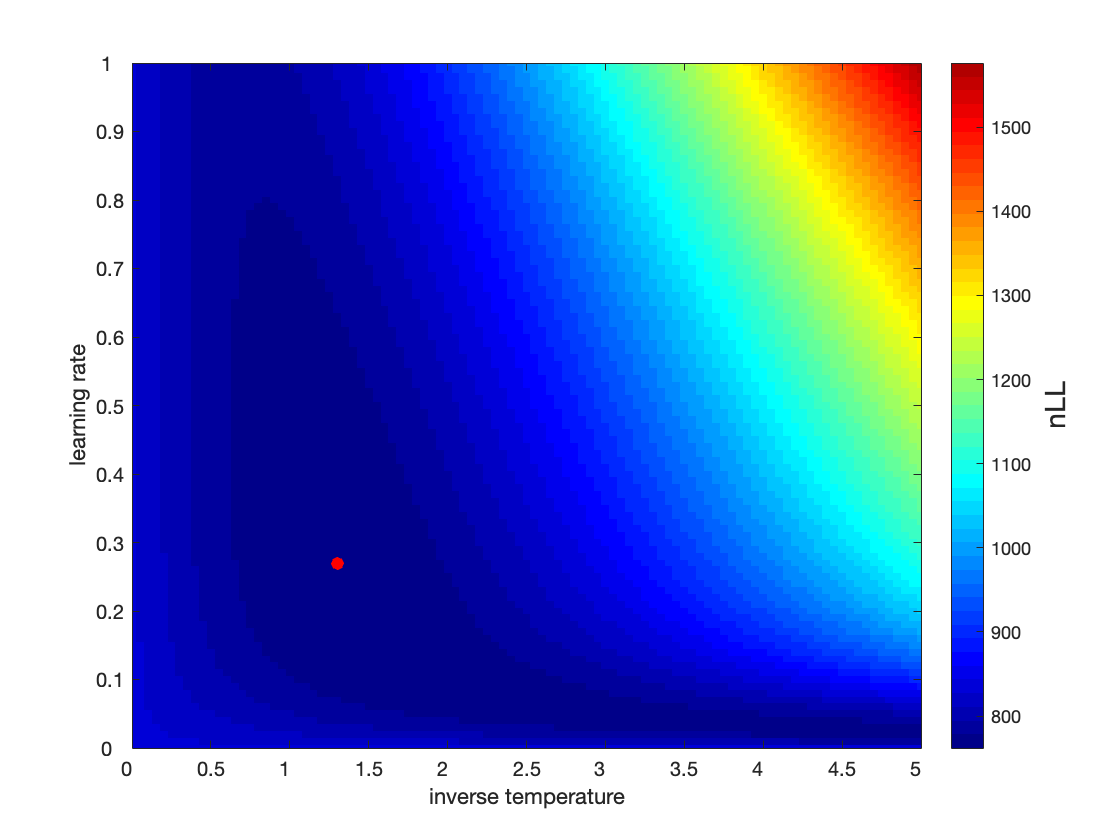

alpha =0.26
inv. temp =1.3


In [33]:
%% plot grid search results

figure

imagesc(flipud(nLL))
hold on
xlabel('inverse temperature')
ylabel('learning rate')

xt = linspace(1,length(temp_mat),11);
xtl = linspace(min(temp_mat),max(temp_mat),11);

yt = linspace(1,length(alpha_mat),11);
ytl = linspace(min(alpha_mat),max(alpha_mat),11);

set(gca,'XLim',[1 length(temp_mat)],...
    'XTick',xt,...
    'XTickLabel',xtl,...
    'YLim',[1 length(alpha_mat)],...
    'YTick',yt,...
    'YTickLabel',fliplr(ytl))


cb= colorbar();
ylabel(cb,'nLL','FontSize',14)


[I,J] = find(nLL == min(min(nLL)));

disp(strcat('alpha = ',num2str(alpha_mat(I))))
disp(strcat('inv. temp = ',num2str(temp_mat(J))))


plot(J,length(alpha_mat)-I,'o',...
    'MarkerFaceColor',[1,0,0],...
    'MarkerEdgeColor',[1,0,0])



c = jet(50);
colormap(c);

Vous pouvez remarquer que les résultats sont similaires mais pas indentiques à la première fois que nous avons exécuté le gridsearch, cela est du à la nature stochastique de la randomisation des essais et du processus qui engenre la probabilté de choisir et les choix dans le Qmodel.

## Méthode 2: Utiliser une fonction d'optimisation

La solution typiquement utilisé c'est de ne pas explorer systematiquement tout l'espace des paramètres comme dnas le grid search, mais de utiliser une fonction d'optimisation. 

Nous allons utiliser une fonction qui existe qui s'appelle *fminsearch*. Cette fonction permet de trouver la valeur minimale de la fonction (comme par example notre modèle) et elle renvoie une valeur scalaire. 

Notre cas, nous avons la fonction estimateQ qui recoit comme input les valeurs des parametres libres et le comportement du participant et qui renvoie comme output la vraisemblance négative (nLL) des ces paramètres par rapport à la modèlisation du comportement du participant.

La function *fminsearch* commence initialement à un point particulier (que nous devons définir au préalable) et exécute cherche la combinasoins de parametres libres qui permet de minimiser la vraisemblance négative (nLL). Il suit l'approche de l'algorithme du simplexe de Nelder-Mead. L'algorithme utilisé est une méthode de recherche directe et n'utilise pas de gradient analytique complexe.


### Code avec fonction d'optimisation pour le Qmodel avec plusieurs bloques d'apprentissage

Dans cette partie du code nous allons faire appel à des fonctions et modèle que nous avons dans la parte du gridsearch:


- **dans le dossier "my_models" :** il y a une fonction qui s'appelle Qmodel, qui produit des choix simulés du modèle avec certains paramètres libres (alpha et inv_temp) et certaines caractéristiques de la tâche expérimentale comme le nombre d'essais (ntrials) et le nombre de blocs d'apprentissage (nruns).

- **dans le dossier "my_functions" :** il y a une fonction qui s'appelle estimateQ qui exécute nous renvoie la vraisemblance négative, étant donné  une combinaisons de valeur des paramètres libres (param), les choix (ch) et l'historique des récompenses obtenues (r) ainsi que les caractéristiques de la tâche (nruns) d'un certain participant.


Nous les avons rajouté dans le path au début de ce code, donc pas besoin de le refaire. De même nous avons aussi déjà crée les données de notre participant sythetique et défini les paramètres de la tâche.


### Code étape 1: définir le point initiale pour le search

In [39]:
% here we test with an optimization function
x0 = [1 0.1]; % initial point of the exploration 5 temp and 0.5 alpha


### Code étape 2: définir le valeur limites des nos paramètres libres

In [35]:
xmin = [0 0]; % min : première valuer c'est beta, deuxième c'est alpha
xmax = [5 1]; % max : première valuer c'est beta, deuxième c'est alpha

### Code étape 3: définir les parametres de la fonction d'optimisation

In [38]:
% we define the options of the optimization function 
options = optimset('Algorithm', 'interior-point', 'Display', 'iter-detailed', 'MaxIter', 10000); % These increase the number of iterations to ensure the convergence


### code étape 4: executer la fonction

In [43]:
[parameters,nll,~,~,~]       = fmincon(@(x) estimateQ(x,sim_ch,sim_r, nruns),x0,[],[],[],[],xmin,xmax,[],options);
parameters

                                            First-order      Norm of
 Iter F-count            f(x)  Feasibility   optimality         step
    0       3    3.637139e+04    0.000e+00    3.247e+03
    1       8    3.541273e+04    0.000e+00    1.606e+02    5.197e-01
    2      20    3.541210e+04    0.000e+00    3.657e+01    2.328e-02
    3      25    3.541196e+04    0.000e+00    1.233e+02    1.274e-02
    4      28    3.541173e+04    0.000e+00    3.826e+00    7.464e-03
    5      31    3.541172e+04    0.000e+00    3.233e-01    8.921e-04
    6      34    3.541172e+04    0.000e+00    1.000e-01    6.486e-05
    7      37    3.541172e+04    0.000e+00    2.000e-02    1.233e-05
    8      40    3.541172e+04    0.000e+00    9.630e-03    4.126e-06
    9      43    3.541172e+04    0.000e+00    6.670e-03    1.010e-06
   10      48    3.541172e+04    0.000e+00    8.401e-04    9.392e-07
   11      51    3.541172e+04    0.000e+00    6.513e-03    6.241e-08
   12      58    3.541172e+04    0.000e+00    3

parameters = 1x2 double
    1.4816    0.3114